In [1]:
import os
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from datetime import datetime
from PIL import Image
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import mlflow





In [2]:
#Clear GPU memory and set up the logging of the experiment with mlflow
K.clear_session()
mlflow.set_experiment('lung_project')
mlflow.autolog()

2023/05/16 15:55:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [3]:
batch_size = 32

In [4]:
image_size = (255, 255)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.15,
    subset="training",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'combined_dataset',
    validation_split=0.15,
    subset="validation",
    label_mode = 'int',
    labels = 'inferred',
    seed=1336,
    image_size=image_size,
    interpolation = 'bilinear',
    batch_size=batch_size,
    shuffle = True,
)


Found 16752 files belonging to 3 classes.
Using 14240 files for training.
Found 16752 files belonging to 3 classes.
Using 2512 files for validation.


In [23]:
imput = (255,255,3)

In [24]:
imput = (255,255,3)

model=models.Sequential()

model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=imput))


model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))
model.add(layers.RandomContrast(0.2))

#Estas me petan la dimension de entrada a la densa. Debería haber un resizing 
# model.add(layers.RandomWidth(0.2))
# model.add(layers.RandomHeight(0.2))


model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Add flatten layer
model.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0

In [25]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'


# Callbacks

In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath_model,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_freq="epoch",
save_best_only=True)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='auto', verbose = 1, )

In [28]:
epochs = 100
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)

2023/03/15 18:06:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a1091872c0c246f699199efdeeec2ef9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/100
445/445 [==============================] - 132s 285ms/step - loss: 0.5011 - accuracy: 0.7787 - val_loss: 0.3287 - val_accuracy: 0.8631
Epoch 2/100
445/445 [==============================] - 94s 211ms/step - loss: 0.3760 - accuracy: 0.8472 - val_loss: 0.3408 - val_accuracy: 0.8376
Epoch 3/100
445/445 [==============================] - 95s 213ms/step - loss: 0.3097 - accuracy: 0.8711 - val_loss: 0.3118 - val_accuracy: 0.8643
Epoch 4/100
445/445 [==============================] - 104s 234ms/step - loss: 0.2884 - accuracy: 0.8826 - val_loss: 0.2560 - val_accuracy: 0.8854
Epoch 5/100
445/445 [==============================] - 120s 269ms/step - loss: 0.2599 - accuracy: 0.8937 - val_loss: 0.1837 - val_accuracy: 0.9260
Epoch 6/100
445/445 [==============================] - 122s 274ms/step - loss: 0.2407 - accuracy: 0.9015 - val_loss: 0.2719 - val_accuracy: 0.8790
Epoch 7/100
445/445 [==============================] - 124s 277ms/step - loss: 0.2309 - accuracy: 0.9063 - val_loss: 0.1

2023/03/15 20:40:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [29]:
#Guardo el modelo en la última epoch. Esto 
model.save(folder_date + '/modelo_entrenado.h5')


In [30]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
folder_date + "/accuracy.png"

'old_models/2023_03_15-06_06_37_PM/accuracy.png'

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


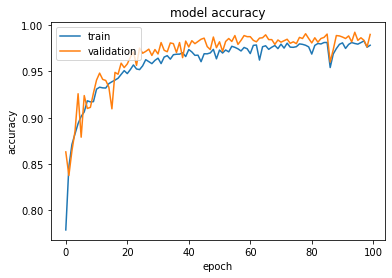

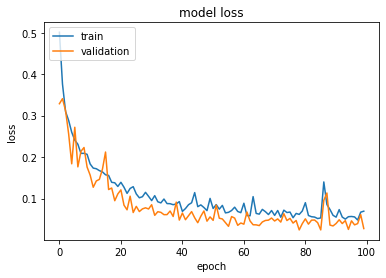

In [32]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(folder_date + "/loss.png")
plt.show()





Preguntas, cómo puedo gestionar datos que vienen de dos distribuciones distintas?



# This is a section to evaluate the model on te test data

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support


[0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


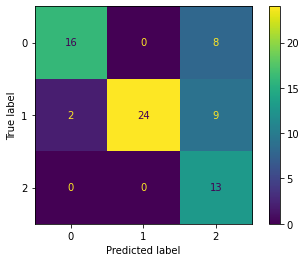

In [34]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []

directory = "test_set"

for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(255,255))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)



    prediction = model.predict(x)
    
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca' in filename:
        true_labels.append(0)
    elif 'scc' in filename or ' e ' in filename:
        true_labels.append(2)
    elif 'lungn' or ' N ' in filename:
        true_labels.append(1)
   
    

    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
precision_recall_fscore_support(true_labels, predicted_labels)


disp.plot()
plt.show()



#Predice mal en las muestras de Henar. Veremos con el nuevo dataset, pero quizá haya que hacer un training con peso Opciones:

Undersample the larger distribution: randomly remove examples from the larger distribution until it matches the size of the smaller one.

Oversample the smaller distribution: randomly duplicate examples from the smaller distribution until it matches the size of the larger one.

Data augmentation: generate new examples from the smaller distribution using techniques like rotation, flipping, or zooming.

Use class weights: adjust the loss function of your CNN to assign higher weights to the smaller distribution so that it receives more emphasis during training.

Fine-tuning: you could use a pre-trained model to initialize the weights and only fine-tune the last few layers to fit the imbalanced data.

1. Domain shift
2. 